# Ground Effect

When an aircraft is flying close to the ground, it experiences an increase in lift and reduction in induced drag due to the formation of a small cushion of air under the aircraft. This phenomenon is known as ground effect. The increase in lift gives the pilot an experience of floating in the air which facilitates a smoother landing. As the aircraft flies closer to the ground, the vortices at the wing tip don't form due to the proximity to the ground. This reduces the induced drag on the aircraft thereby increasing the speed and lift of the aircraft. The ground effect is also useful in case of automobiles. The downforce increases as the vortices are not formed which facilitates turning around corners with greater ease.

For an aircraft, the gorund effect can prove highly useful, especially during landing as the increased lift could allow for higher angle of attack of the airfoil without stall due to the increased lift force by the ground effect. The aim of this project is to analyze the ground effect phenomenon and understand the behavior of the airfoil in close proximity with the ground. This project aims to study the ground effect using a 2D inviscid panel method using vortex-source panels. The ground effect will be incorporated into the analysis by using the [Method of Images](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/07_Lesson07_methodOfImages.ipynb), i.e. creating a mirror image of the airfoil about the x-axis.

In [1]:
# import libraries and modules needed
import os
import numpy
import math
from scipy import integrate
from matplotlib import pyplot
# embed plots into the notebook
%matplotlib inline

The airfoil is discretized into a number of panels and the strength of the singularities on each panel is calculated by buliding and solving a system of linear equations.

Let's begin by creating class for panel and functions to define panels for selected airfoils. Further all the classes and functions needed for the solution before proceeding with the script to be executed.

In [2]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [3]:
def define_panels(x,y):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    N = len(x)-1
    panels = numpy.empty(N,dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    return panels

The freestream is stored in a class object defined below

In [4]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

## Section 1: Without Ground Effect

As we assume potential flow, the solution is obtained simply by a superposition of potential flow solutions for each panel. The potential function for a vortex-source panel discretization for a single element airfoil is:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha + \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j - \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The velocities in a certain direction are computed by differentiating the potential with respect to that direction. Also, at the surface of the airfoil, no penetration is assumed and a flow tangency boundary conditions is imposed at the center of each panel as:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.
$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j - \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The integral in the velocity function is obtained by chain rule and we use the scipy function quad to integrate the integrand over the panel length. The general function for the integration is defined below.

In [5]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk + (y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

The contribution of the sources on the normal velocity is computed by the function below

In [6]:
def source_matrix_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix normal to the airfoil.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)              # source contribution on a panel from itself
    
    # source contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
    return A

The contribution of the vortices on the normal velocity is computed by the function below

In [7]:
def vortex_matrix_normal(panels):
    """
    Builds the vortex contribution matrix
    for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix normal to the airfoil.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    return A

### Enforcing the Kutta Condition

The kutta condition implies that the flow must lead off the trailing edge of the airfoil smoothly without separation. For this, we enforce the pressure co-efficient on the first panel equal to the pressure co-efficient on the last panel. For this, the tangential velocity on the first panel is set equal to the tangential velocity on the last panel since the pressure co-efficient is dependant on the flow velocity at a certain point.

In [8]:
def build_matrix_single_element(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system arising from 
    source and vortex contributions for a single airfoil
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1,:-1] = B_vortex[0, :] + B_vortex[-1, :]
    A[-1, -1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    
    return A

In [9]:
def build_freestream_rhs_single_element(panels, freestream):
    """
    Builds the right-hand side of the system arising from 
    the freestream contribution for a single airfoil.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [10]:
def compute_tangential_velocity_single_element(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [11]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

This project aims at simulating the behavior of 3 different airfoils viz. NACA0012 (the most standard symmetric airfoil), NACA 2213 (used in the Boeing 75 PT-13 Kaydet (N2S) biplane) and NACA 4412 (a highly cambered airfoil used in various aircrafts). The airfoil data was obtained from xflr5 NACA database.

We begin by simulating the behavior of these airfoils without the ground effect in this section and further compare with the results obtained by adding ground to the system.

Beginning with NACA 0012

In [12]:
filepath = os.path.join('resources','NACA0012.dat')
with open(filepath,'r') as filename:
    x_0012, y_0012 = numpy.loadtxt(filename,dtype=float,unpack=True)

panels_0012 = define_panels(x_0012,y_0012)
u_inf, alpha = 1.0, numpy.linspace(0,25,10)          # varying alpha to get relation between lift and angle of attack

In [13]:
lift_0012 = numpy.zeros(len(alpha),dtype=float)
A_source = source_matrix_normal(panels_0012)
B_vortex = vortex_matrix_normal(panels_0012)
A = build_matrix_single_element(A_source, B_vortex)

for i in range(len(alpha)):
    freestream = Freestream(u_inf,alpha[i])
    b = build_freestream_rhs_single_element(panels_0012, freestream)
    strengths = numpy.linalg.solve(A,b)
    for j, panel in enumerate(panels_0012):
        panel.sigma = strengths[j]
    gamma = strengths[-1]
    compute_tangential_velocity_single_element(panels_0012, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels_0012, freestream)
    
    for panel in panels_0012:
        lift_0012[i] -= panel.cp*panel.length*numpy.sin(panel.beta)    

The next airfoil to be analyzed is NACA 2213

In [14]:
filepath = os.path.join('resources','NACA2213.dat')
with open(filepath,'r') as filename:
    x_2213, y_2213 = numpy.loadtxt(filename,dtype=float,unpack=True)

panels_2213 = define_panels(x_2213,y_2213)

In [15]:
lift_2213 = numpy.zeros(len(alpha),dtype=float)
A_source = source_matrix_normal(panels_2213)
B_vortex = vortex_matrix_normal(panels_2213)
A = build_matrix_single_element(A_source, B_vortex)

for i in range(len(alpha)):
    freestream = Freestream(u_inf,alpha[i])
    b = build_freestream_rhs_single_element(panels_2213, freestream)
    strengths = numpy.linalg.solve(A,b)
    for j, panel in enumerate(panels_2213):
        panel.sigma = strengths[j]
    gamma = strengths[-1]
    compute_tangential_velocity_single_element(panels_2213, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels_2213, freestream)
    
    for panel in panels_2213:
        lift_2213[i] -= panel.cp*panel.length*numpy.sin(panel.beta)    

And then we proceed to the highly cambered NACA 4412 and compare the lifts and angles of attack for the three airfoils.


In [16]:
filepath = os.path.join('resources','NACA4412.dat')
with open(filepath,'r') as filename:
    x_4412, y_4412 = numpy.loadtxt(filename,dtype=float,unpack=True)

panels_4412 = define_panels(x_4412,y_4412)

In [17]:
lift_4412 = numpy.zeros(len(alpha),dtype=float)
A_source = source_matrix_normal(panels_4412)
B_vortex = vortex_matrix_normal(panels_4412)
A = build_matrix_single_element(A_source, B_vortex)

for i in range(len(alpha)):
    freestream = Freestream(u_inf,alpha[i])
    b = build_freestream_rhs_single_element(panels_4412, freestream)
    strengths = numpy.linalg.solve(A,b)
    for j, panel in enumerate(panels_4412):
        panel.sigma = strengths[j]
    gamma = strengths[-1]
    compute_tangential_velocity_single_element(panels_4412, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels_4412, freestream)
    
    for panel in panels_4412:
        lift_4412[i] -= panel.cp*panel.length*numpy.sin(panel.beta)

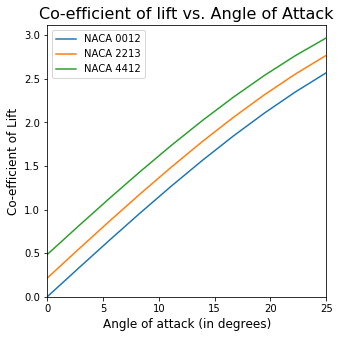

In [18]:
size=5
pyplot.figure(figsize=(size,size))
pyplot.plot(alpha, lift_0012, label = 'NACA 0012')
pyplot.plot(alpha, lift_2213, label = 'NACA 2213')
pyplot.plot(alpha, lift_4412, label = 'NACA 4412')
pyplot.legend(loc = 'best')
pyplot.title('Co-efficient of lift vs. Angle of Attack',fontsize=16)
pyplot.xlabel('Angle of attack (in degrees)',fontsize=12)
pyplot.ylabel('Co-efficient of Lift',fontsize=12)
# pyplot.axis('scaled')
pyplot.xlim(alpha[0],alpha[-1])
pyplot.ylim(bottom = 0);

The above results do not show the stall phenomenon, i.e. sudden drop in lift at high angle of attack. Stall occurs due to flow separation and the potential flow assumption does not account for separation of flow and we see an almost linearly increasing relation of lift and angle of attack.

To account for the viscous effects and observe stall, xflr5 is used with viscous and boundary layer correction enabled. The results obtained using xflr5 are shown in the image below. Until the stall angle is reached, the results from both the methods are in close proximity with each other which could be basis for considering that the solution is acceptable.

<img src="resources/XFLR5_results/viscous_results.jpg">

In the above graph, the yellow line is for NACA 0012, the green line is for NACA 2213 and the white line is for NACA 4412



## Section 2: With Ground Effect

Now, let's proceed to modelling the ground effect by adding ground to the system using the method of images. When the image is added to the system, the model becomes a system with 2 airfoils and must be dealt with as a multi-element method is a similar fashion as [this assignment](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/11_Lesson11_Assignment.ipynb)).

For this case, the potential function is calculated as 

$$
\begin{split}
\phi(x, y) &= U_{\infty}x\cos\alpha + U_{\infty}y\sin\alpha + \int_{main} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds + \int_{image} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds \\
& - \int_{main} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds - \int_{image} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds
\end{split}
$$

On differentiating the potential in the normal and tangential direction, we can build the system of linear equations in a similar fashion as the previous case with a single airfoil. The source and vortex contribution matrices in the normal direction remain unchanged and we build the singularity matrix for the two elements and enforce the kutta condition using the function below

In [19]:
def build_matrix_multi_element(panels):
    """
    Builds the left-hand side matrix of the system arising from
    source and vortex contributions for a multi-element airfoil (2 elements)
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels
    
    Returns
    ----------
    A: 2D numpy array of floats
        The singularity matrix normal to the airfoil
    
    At: 2D numpy array of foats
        The singularity matrix tangential to the airfoil
    """
    N = len(panels)                                      # no. of panels
    kutta = numpy.empty((2,N+2), dtype=float)            # initializing kutta condition matrix
    At = numpy.empty((N,N+2), dtype=float)               # initializing tangential contribution matrix
    main = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    flap = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    B = numpy.empty((N,2), dtype=float)                  # initializing vortex contribution matrix
    A = numpy.empty((N+2,N+2), dtype=float)              # initializing singularity matrix
    
    An = source_matrix_normal(panels)
    Bn = vortex_matrix_normal(panels)
    
    for i, panel_i in enumerate(panels):
        B[i,0] = numpy.sum(Bn[i,:int(N/2)])
        B[i,1] = numpy.sum(Bn[i,int(N/2):])
    
    for i, panel_i in enumerate(panels):
        main[i] = numpy.sum(An[i,:int(N/2)])
        flap[i] = numpy.sum(An[i,int(N/2):])
    
    At[:N,:N] = Bn
    At[:,-2] = -main
    At[:,-1] = -flap
    kutta[0,:] = At[0,:] + At[int(N/2-1),:]
    kutta[1,:] = At[int(N/2),:] + At[-1,:]
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, B, kutta
    
    return A, At

The freestream contribution matrix on the RHS is calculated using the function defined below

In [20]:
def build_freestream_rhs_multi_element(panels, freestream):
    """
    Builds the right hand-side of the system arising from the 
    freestream contribution for a multi-element airfoil (2 elements).
    
    Parameters
    ----------
    panels: Panel object (Numpy 1d array)
        Class of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: Numpy 1d array (float)
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf * (math.sin(freestream.alpha-panels[0].beta) + math.sin(freestream.alpha-panels[int(N/2-1)].beta))
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf * (math.sin(freestream.alpha-panels[int(N/2)].beta) + math.sin(freestream.alpha-panels[-1].beta))
    return b

The tangential velocity is computed similar to the previous section. However, as the number of equations in the multi-element system are higher, we define the function to calculate tangential velocity on the surface of the airfoil once again.

In [21]:
def compute_tangential_velocity_multi_element(panels, freestream, gamma, At):
    """
    Computes the tangential velocity along the 
    airfoil surface for a multi-element airfoil
    
    Parameters
    ----------
    panels: Panel object (1D Numpy array)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: 1D Numpy Array of floats
        The strength of the vortices on the panels
    At: 2D Numpy Array of floats
        The singularity matrix tangential to the airfoil
    """
    N = len(panels)
    strengths = numpy.append([panel.sigma for panel in panels],gamma)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At,strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

Just like the previous section, the analysis begins with NACA 0012 airfoil. This time we add an image of the airfoil to produce the ground effect.

However, when dealing with ground effect, the ground is preferred at y=0 at all times. Hence, the freestream is always kept horizontal and the airfoil is rotated to simulate the angle of attack. The angle of attack for teh ground effect will be considered for $\alpha$ varying from $0^o$ to $25^o$ and for height from the ground varying from 0.05 to 1.

In [22]:
def rotate(x,y,xc,yc,theta):
    """
    Funtion to rotate a given set of points
    about a certain point of rotation
    
    Parameters
    ----------
    x: 1D Numpy Array of floats
        x co-ordinates
    y: 1D Numpy Array of floats
        y-co-ordinates
    xc: float
        x co-ordinate of the center of rotation
    yc: float
        y co-ordinate of the center of rotation
    theta: float
        angle of rotation (in degrees)
    """
    theta = theta * math.pi/180
    x, y = x - xc, y - yc                              # translating hinge point to origin
    x1 = x * math.cos(theta) + y * math.sin(theta)     # rotation 
    y1 = -x * math.sin(theta) + y * math.cos(theta)
    x, y = x1 + xc, y1 + yc                            # translating back to original position
    
    return x,y

In [23]:
filepath = os.path.join('resources','NACA0012.dat')
with open(filepath,'r') as filename:
    x,y = numpy.loadtxt(filename,unpack=True)

alpha = numpy.linspace(0,25,5)
h = numpy.array([0.05,0.2,0.5,1.0],dtype=float)
lift_0012 = numpy.zeros((len(h),len(alpha)),dtype=float)

for i in range(len(h)):
    for j in range(len(alpha)):
        x_new,y_new = rotate(x,y,x[0],y[0],alpha[j])
        y_new += h[i]

        panels_main = define_panels(x_new,y_new)
        panels_image = define_panels(x_new,-y_new)
        panels = numpy.concatenate((panels_main, panels_image))

        freestream = Freestream()
        A, At = build_matrix_multi_element(panels)
        b = build_freestream_rhs_multi_element(panels, freestream)

        strengths = numpy.linalg.solve(A,b)
        for k, panel in enumerate(panels):
            panel.sigma = strengths[k]
        gamma = strengths[-2:]

        compute_tangential_velocity_multi_element(panels, freestream, gamma, At)
        compute_pressure_coefficient(panels,freestream)
        
        for panel in panels_main:
            lift_0012[i,j] -= panel.cp*panel.length*numpy.sin(panel.beta)
    

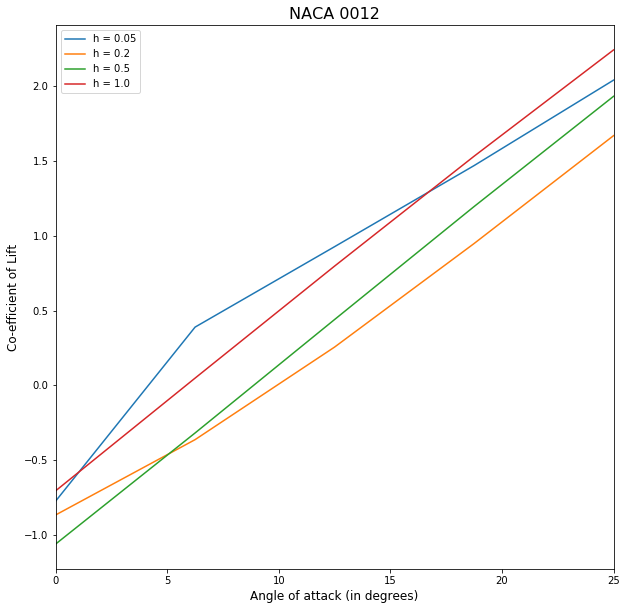

In [24]:
size = 10
pyplot.figure(figsize=(size,size))

for i in range(len(h)):
    pyplot.plot(alpha, lift_0012[i,:], label = 'h = {}'.format(h[i]))

pyplot.legend(loc = 'best')
pyplot.title('NACA 0012',fontsize=16)
pyplot.xlabel('Angle of attack (in degrees)',fontsize=12)
pyplot.ylabel('Co-efficient of Lift',fontsize=12)
pyplot.xlim(alpha[0],alpha[-1]);

At a glance,it is evident that there is some error in the code execution. The origination of error is yet unknown and attempts shall be continually made to work out the error. The analysis for the ground effect was performed in xflr5 and the results are shown in the graph below.

<img src="resources/XFLR5_results/NACA0012_ground_effect.jpg">


NACA 2213

In [25]:
filepath = os.path.join('resources','NACA2213.dat')
with open(filepath,'r') as filename:
    x,y = numpy.loadtxt(filename,unpack=True)

alpha = numpy.linspace(0,25,5)
h = numpy.array([0.05,0.2,0.5,1.0],dtype=float)
lift_2213 = numpy.zeros((len(h),len(alpha)),dtype=float)

for i in range(len(h)):
    for j in range(len(alpha)):
        x_new,y_new = rotate(x,y,x[0],y[0],alpha[j])
        y_new += h[i]

        panels_main = define_panels(x_new,y_new)
        panels_image = define_panels(x_new,-y_new)
        panels = numpy.concatenate((panels_main, panels_image))

        freestream = Freestream()
        A, At = build_matrix_multi_element(panels)
        b = build_freestream_rhs_multi_element(panels, freestream)

        strengths = numpy.linalg.solve(A,b)
        for k, panel in enumerate(panels):
            panel.sigma = strengths[k]
        gamma = strengths[-2:]

        compute_tangential_velocity_multi_element(panels, freestream, gamma, At)
        compute_pressure_coefficient(panels,freestream)
        
        for panel in panels_main:
            lift_2213[i,j] -= panel.cp*panel.length*numpy.sin(panel.beta)
    

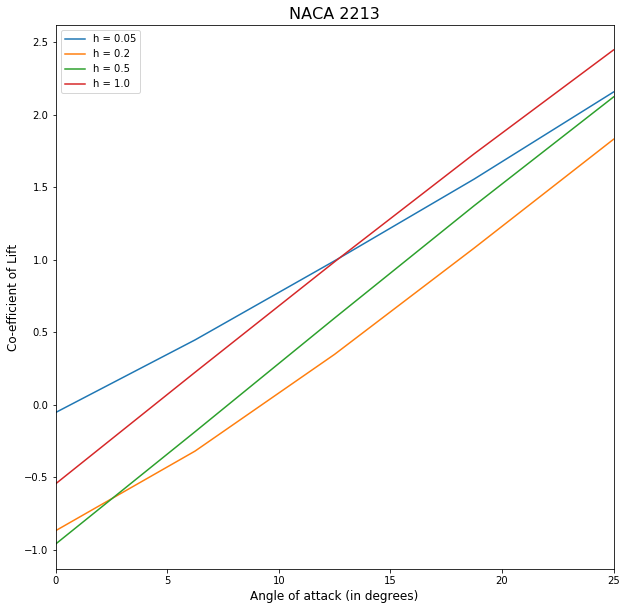

In [26]:
size = 10
pyplot.figure(figsize=(size,size))

for i in range(len(h)):
    pyplot.plot(alpha, lift_2213[i,:], label = 'h = {}'.format(h[i]))

pyplot.legend(loc = 'best')
pyplot.title('NACA 2213',fontsize=16)
pyplot.xlabel('Angle of attack (in degrees)',fontsize=12)
pyplot.ylabel('Co-efficient of Lift',fontsize=12)
pyplot.xlim(alpha[0],alpha[-1]);

The xflr5 results

<img src="resources/XFLR5_results/NACA2213_ground_effect.jpg">

NACA 4412

In [27]:
filepath = os.path.join('resources','NACA4412.dat')
with open(filepath,'r') as filename:
    x,y = numpy.loadtxt(filename,unpack=True)

alpha = numpy.linspace(0,25,5)
h = numpy.array([0.05,0.2,0.5,1.0],dtype=float)
lift_4412 = numpy.zeros((len(h),len(alpha)),dtype=float)

for i in range(len(h)):
    for j in range(len(alpha)):
        x_new,y_new = rotate(x,y,x[0],y[0],alpha[j])
        y_new += h[i]

        panels_main = define_panels(x_new,y_new)
        panels_image = define_panels(x_new,-y_new)
        panels = numpy.concatenate((panels_main, panels_image))

        freestream = Freestream()
        A, At = build_matrix_multi_element(panels)
        b = build_freestream_rhs_multi_element(panels, freestream)

        strengths = numpy.linalg.solve(A,b)
        for k, panel in enumerate(panels):
            panel.sigma = strengths[k]
        gamma = strengths[-2:]

        compute_tangential_velocity_multi_element(panels, freestream, gamma, At)
        compute_pressure_coefficient(panels,freestream)
        
        for panel in panels_main:
            lift_4412[i,j] -= panel.cp*panel.length*numpy.sin(panel.beta)
    

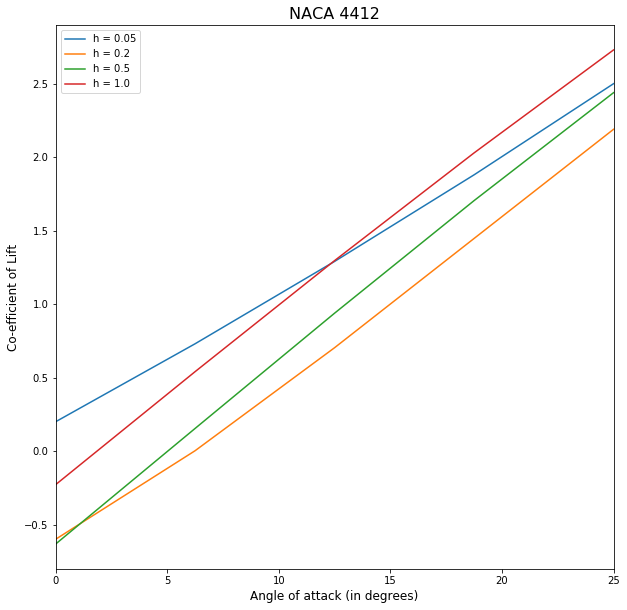

In [29]:
size = 10
pyplot.figure(figsize=(size,size))

for i in range(len(h)):
    pyplot.plot(alpha, lift_4412[i,:], label = 'h = {}'.format(h[i]))

pyplot.legend(loc = 'best')
pyplot.title('NACA 4412',fontsize=16)
pyplot.xlabel('Angle of attack (in degrees)',fontsize=12)
pyplot.ylabel('Co-efficient of Lift',fontsize=12)
pyplot.xlim(alpha[0],alpha[-1]);

The xflr5 results

<img src="resources/XFLR5_results/NACA4412_ground_effect.jpg">